# 尝试运行模型

Jupyter notebook 是交互式的代码IDE，非常适合新手，建议最开始在这里探索我们的模型。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

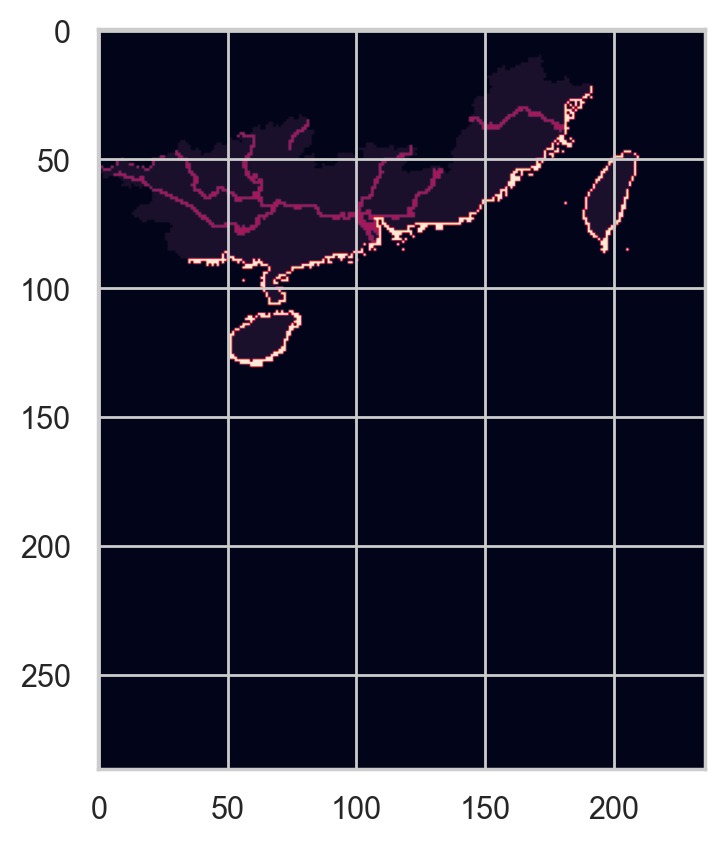

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid")

import rasterio

with rasterio.open(cfg.db.lim_h) as dataset:
    arr = dataset.read(1)
    plt.imshow(arr)

注意下面这里需要把你上面读取的参数配置文件，作为参数`parameters=cfg`输入到模型中。

In [3]:
# 从这个路径加载模型
from abses_sce.model import Model

model = Model(parameters=cfg)
model.params.save_plots = False

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

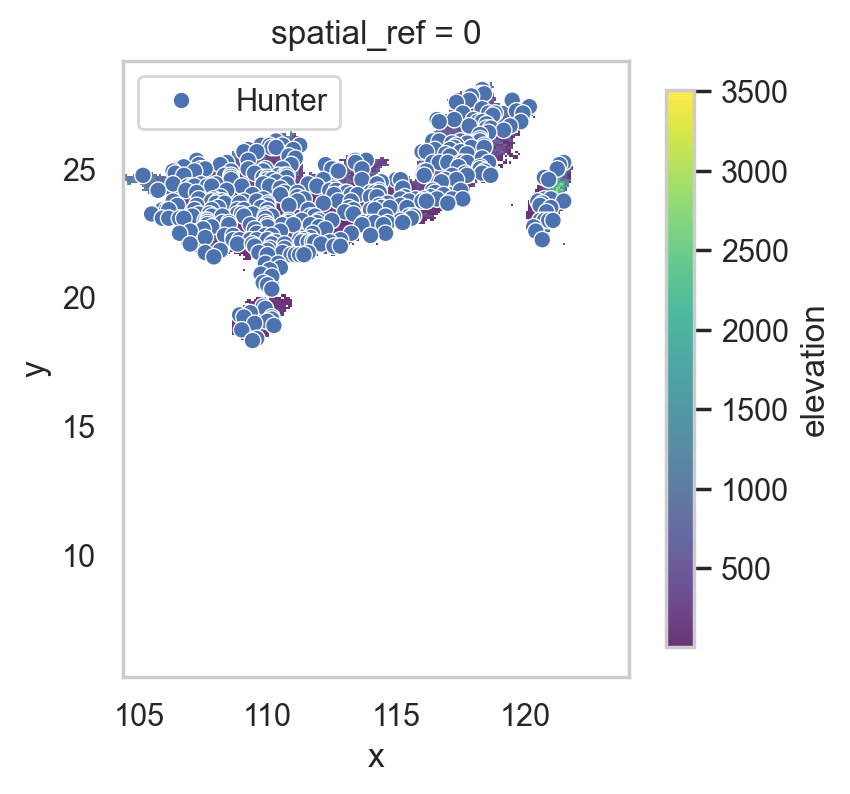

In [4]:
model.nature.plot.show("elevation")

<Axes: xlabel='size', ylabel='Count'>

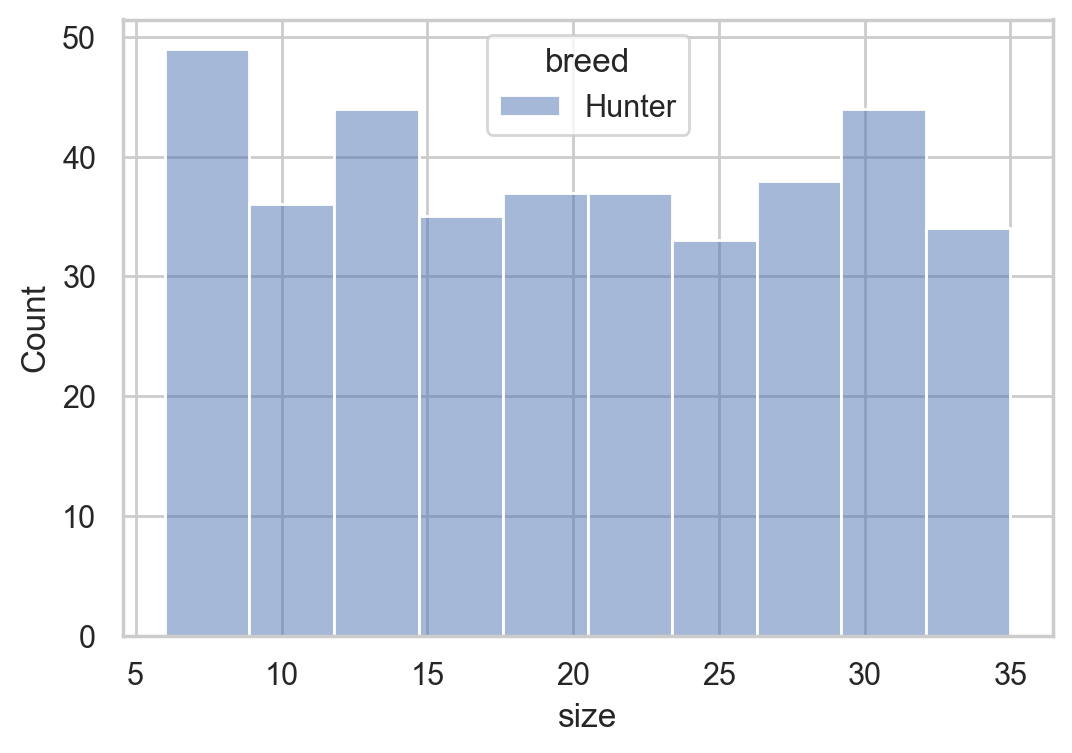

In [5]:
model.actors.plot.hist("size")

农民可以停留的可耕种土地有3074，分布如下图：


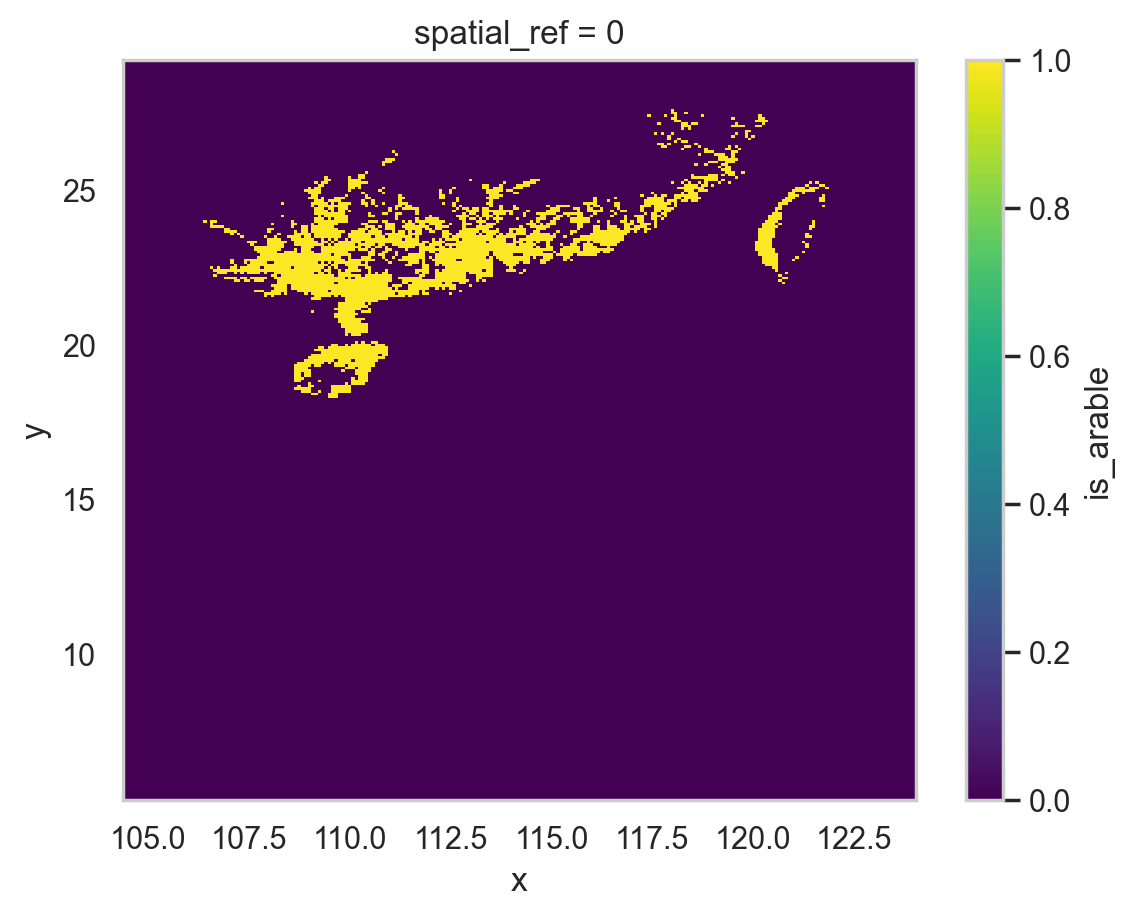

In [6]:
arable_land = model.nature.get_xarray("is_arable")
print(f"农民可以停留的可耕种土地有{arable_land.to_numpy().sum()}，分布如下图：")
arable_land.plot()

水稻农民可以停留的可耕种土地有924，分布如下图：


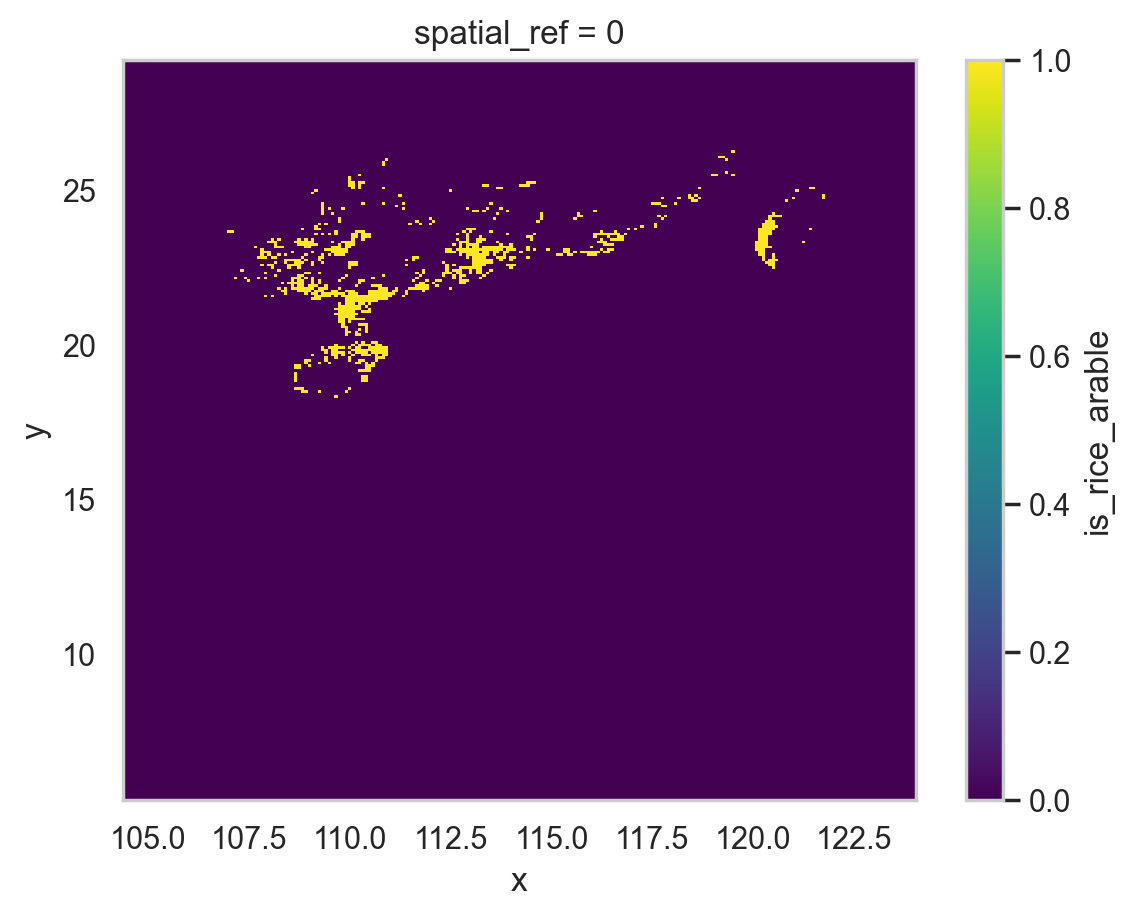

In [7]:
rice_arable = model.nature.patchmodule.get_xarray("is_rice_arable")
print(f"水稻农民可以停留的可耕种土地有{rice_arable.to_numpy().sum()}，分布如下图：")
rice_arable.plot()

增加了初始的 Hunters，随机生成在地图上

In [8]:
model.datacollector.get_model_vars_dataframe()

,len_farmers,len_hunters,len_rice,num_farmers,num_hunters,num_rice


(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>)

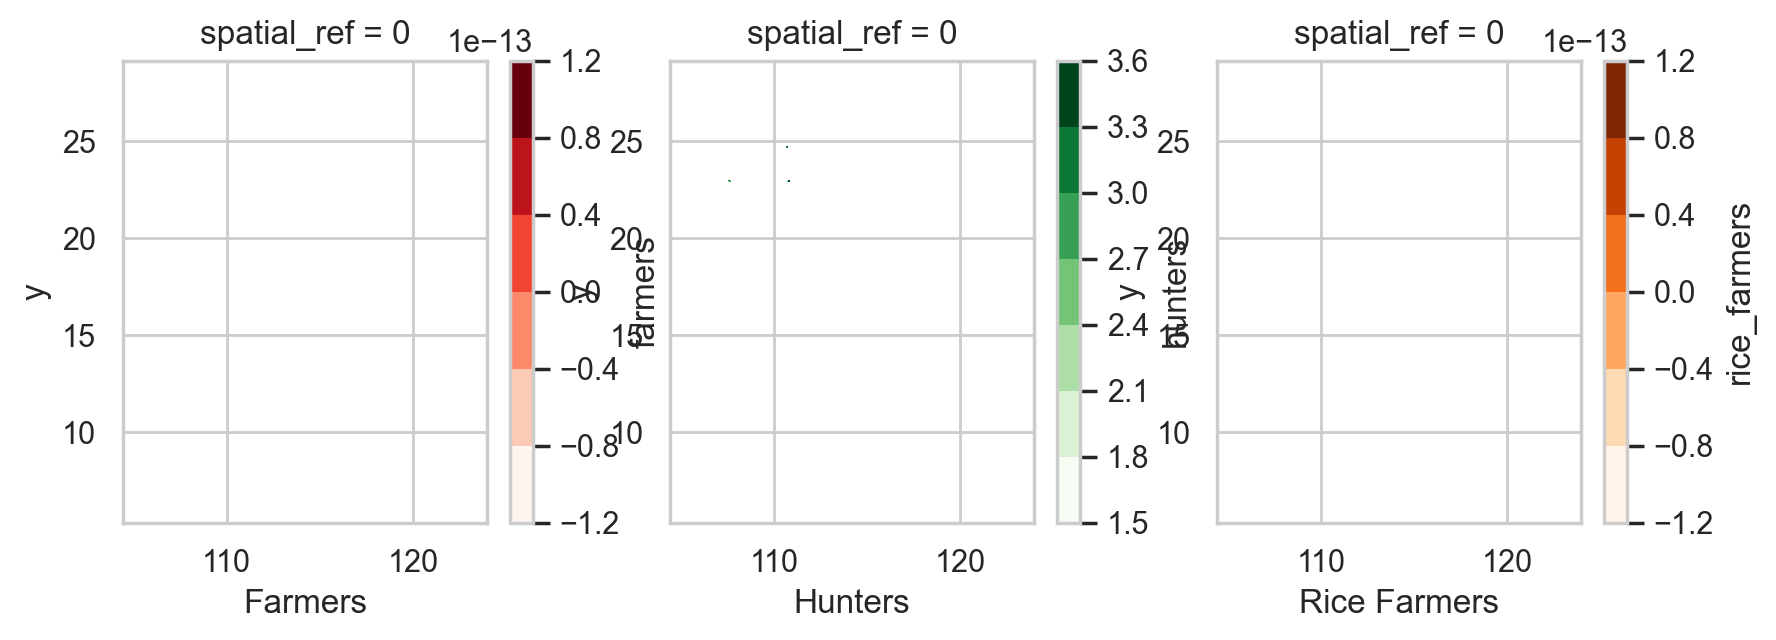

In [9]:
model.plot.heatmap()

设置100年的话，模型的运行可能需要几分钟的时间，以此类推，模型没运算完不要太着急。完成后会自动做出下面的折线图。

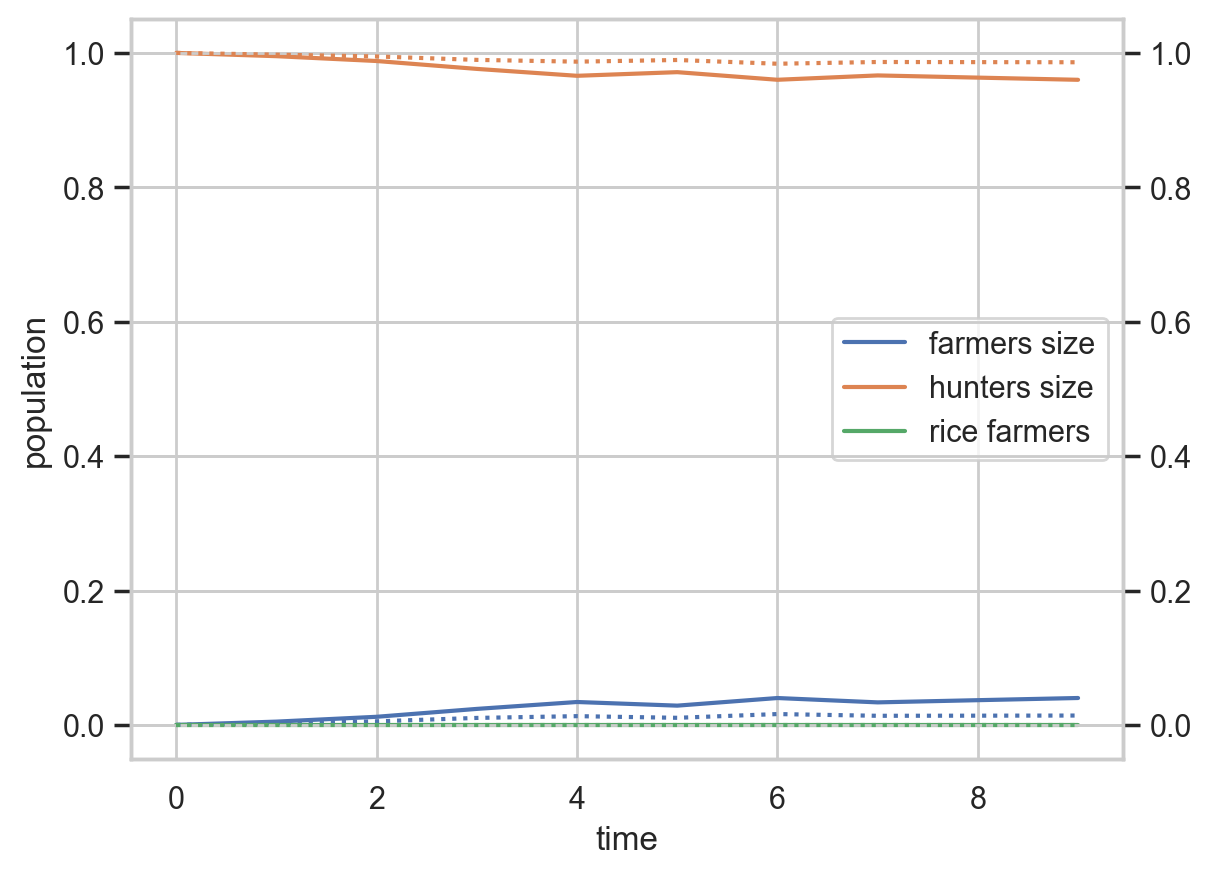

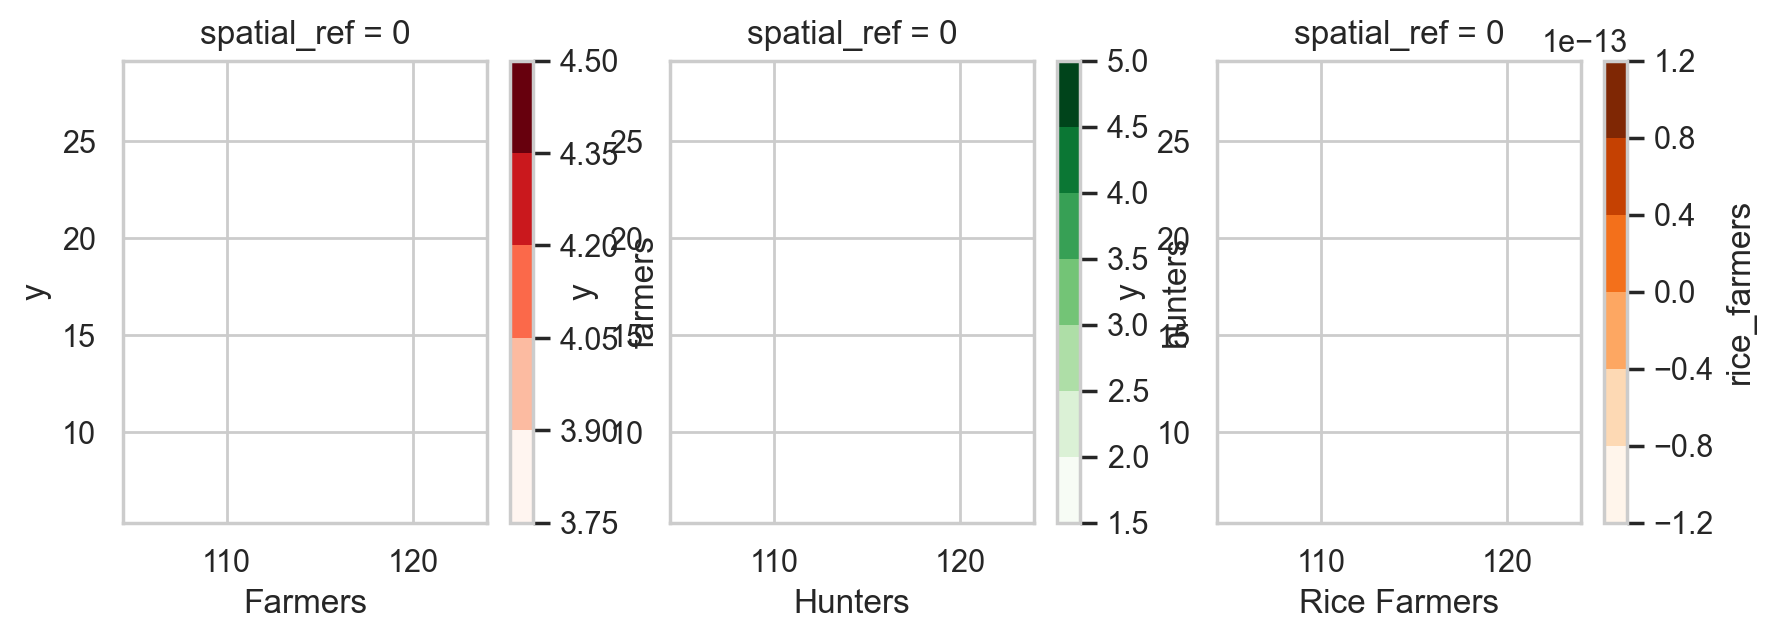

In [10]:
model.run_model()

展示主体的信息

In [11]:
agent = model.actors.random.choice()
agent.report()

unique_id          290
breed           Hunter
size              32.0
position     (126, 56)
dtype: object

(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>)

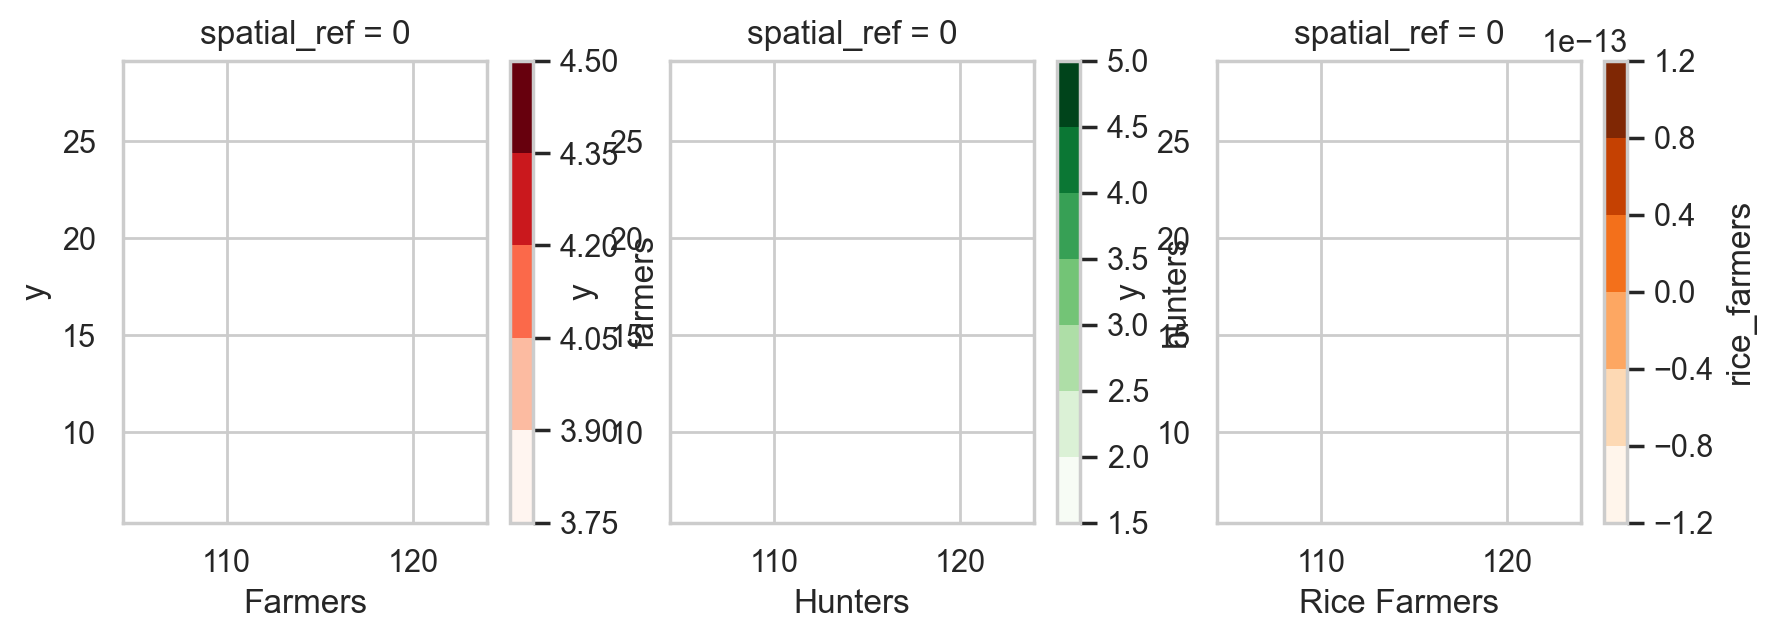

In [12]:
model.plot.heatmap()

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

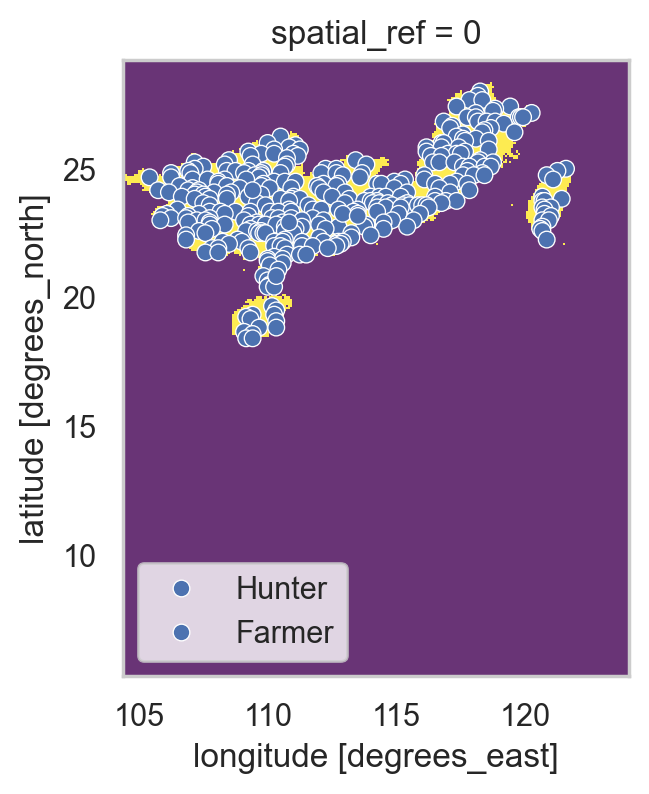

In [13]:
model.nature.plot.show()

In [14]:
model.hunters
model.farmers

<ActorsList: (354)Hunter>

<ActorsList: (5)Farmer>

(<Axes: xlabel='Population'>, <Axes: xlabel='Groups'>)

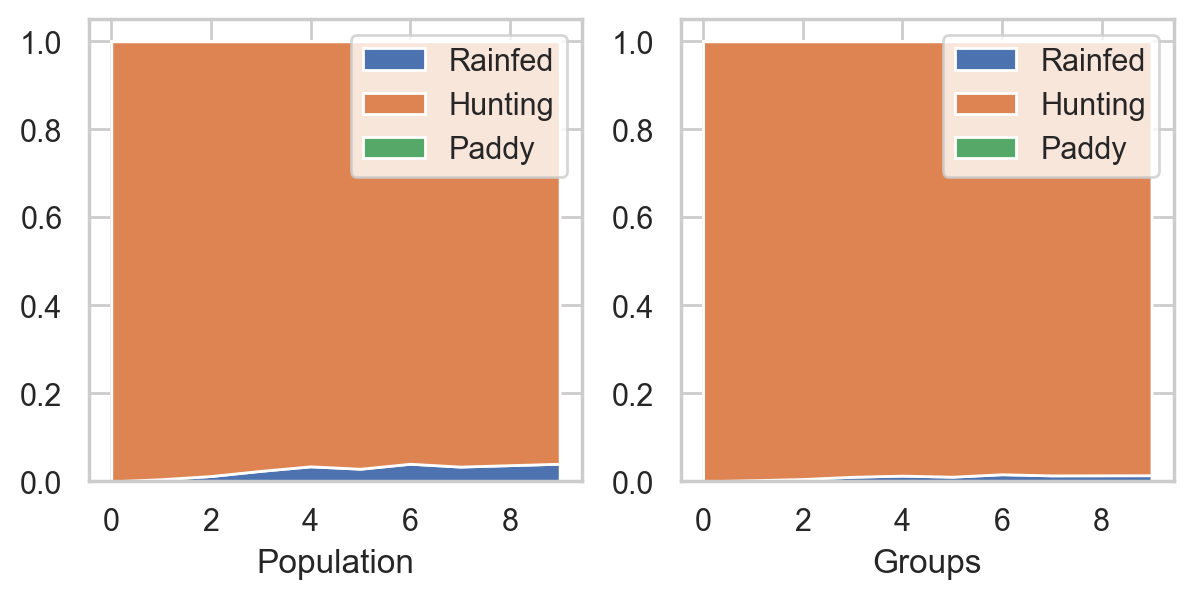

In [15]:
model.plot.stack_dynamic()

<Axes: xlabel='size', ylabel='Count'>

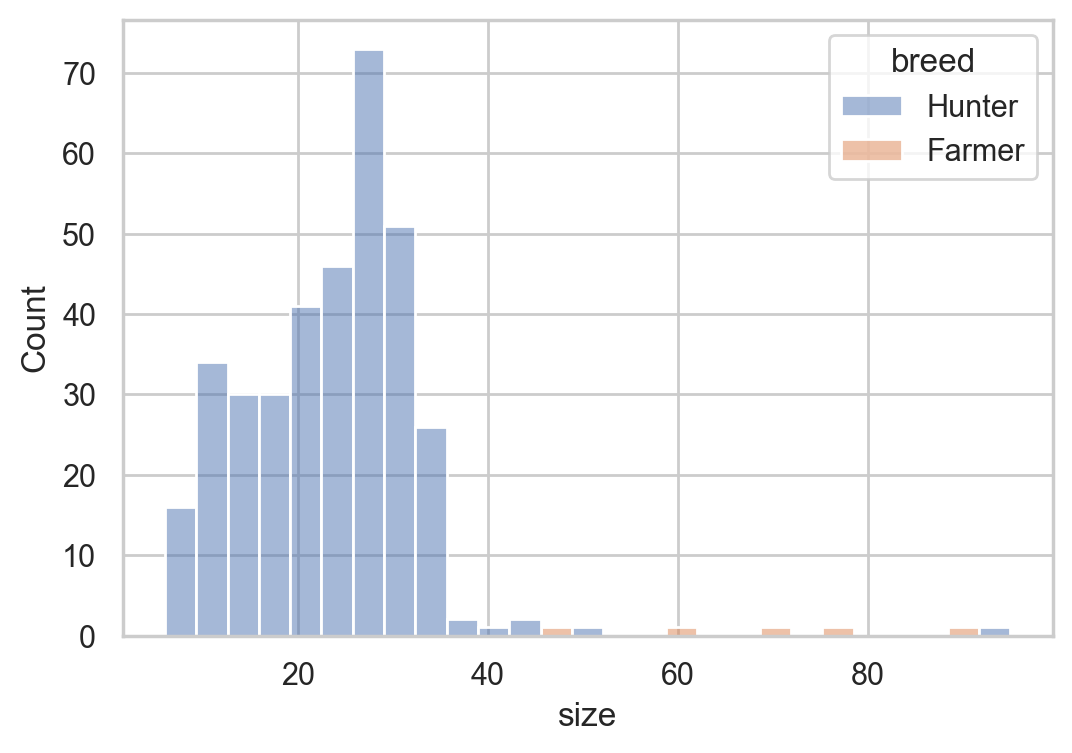

In [16]:
model.actors.plot.hist("size")

In [28]:
from abses_sce.exp import MyExperiment

exp = MyExperiment(Model)
exp.batch_run(cfg=cfg, repeats=10, parallels=5)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
MyExperiment(Model)

<Axes: xlabel='tick', ylabel='num_farmers'>

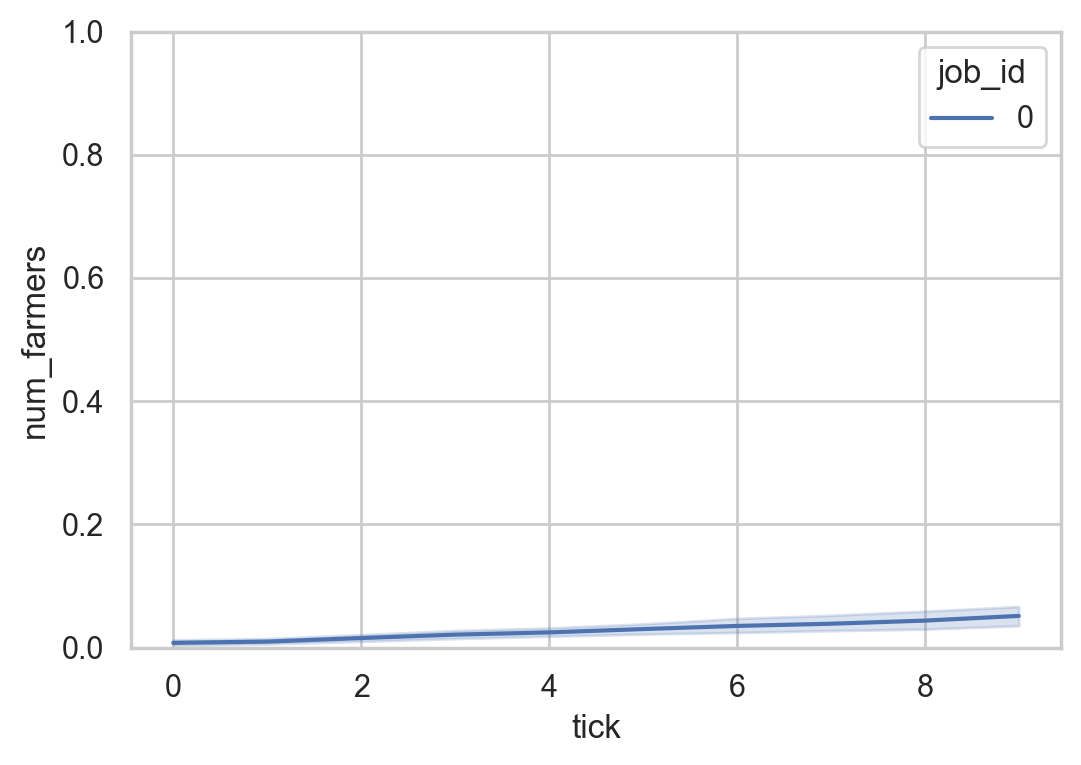

In [29]:
exp.plot_agg_dynamic("farmers", "num")

In [19]:
data = exp.get_model_vars_dataframe()
data.head()

,job_id,repeat_id,tick,len_farmers,len_hunters,len_rice,num_farmers,num_hunters,num_rice
0,0,1,0,0.000000,1.000000,0.0,0.000000,1.000000,0.0
1,0,1,1,0.002646,0.997354,0.0,0.007800,0.992200,0.0
2,0,1,2,0.002660,0.997340,0.0,0.008647,0.991353,0.0
3,0,1,3,0.005420,0.994580,0.0,0.016244,0.983756,0.0
4,0,1,4,0.010695,0.989305,0.0,0.028302,0.971698,0.0


In [20]:
exp.get_model_vars_dataframe()

,job_id,repeat_id,tick,len_farmers,len_hunters,len_rice,num_farmers,num_hunters,num_rice
0,0,1,0,0.000000,1.000000,0.0,0.000000,1.000000,0.0
1,0,1,1,0.002646,0.997354,0.0,0.007800,0.992200,0.0
2,0,1,2,0.002660,0.997340,0.0,0.008647,0.991353,0.0
3,0,1,3,0.005420,0.994580,0.0,0.016244,0.983756,0.0
4,0,1,4,0.010695,0.989305,0.0,0.028302,0.971698,0.0
...,...,...,...,...,...,...,...,...,...
5,0,10,5,0.020725,0.979275,0.0,0.048058,0.951942,0.0
6,0,10,6,0.025575,0.974425,0.0,0.056514,0.943486,0.0
7,0,10,7,0.027848,0.972152,0.0,0.061438,0.938562,0.0
8,0,10,8,0.025840,0.974160,0.0,0.062209,0.937791,0.0


In [ ]:
exp.plo

In [21]:
data = exp.get_model_vars_dataframe()

import seaborn as sns

sns.lineplot(data, x="tick", y="hunters_num", hue="job_id")

ValueError: Could not interpret value `hunters_num` for `y`. An entry with this name does not appear in `data`.

In [ ]:
flag = "num"
if flag == "num":
    cols = ["farmers_num", "hunters_num", "rice_num"]
elif flag == "len":
    cols = ["len_farmers", "len_hunters", "len_rice"]
ratios = data[cols].div(data[cols].sum(axis=1), axis=0)

In [ ]:
data[["tick", "repeat_id"]]